# Number game

## Environment setup

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

class NumberGame:
    def __init__(self,threshold = 0.5, min_number=1, max_number=100):
        self._threshold = threshold
        self._min_number = min_number
        self._max_number = max_number
        self._size = max_number-min_number+1
        self._candidates = np.linspace(self._min_number, self._max_number, self._size, dtype=np.int64)
        self._concept = self.make_concept()

    def make_concept(self):
        idx = [random.random() >= self._threshold for _ in range(self._size)]
        concept = np.zeros([1, self._size])
        concept[0, self._candidates[idx]-1] = 1
        return concept.squeeze(0)

    def reset(self):
        self._concept = self.make_concept()

    def make_samples(self):
        n_concept = sum(self._concept)
        n_samples = random.randint(1, n_concept)
        samples = np.zeros([1, self._size])
        samples[0, np.random.choice(self._candidates[np.where(self._concept == 1)]-1, n_samples)] = 1
        return samples.squeeze(0)

    @property
    def threshold(self):
        return self._threshold

    @threshold.setter
    def threshold(self, x):
        self._threshold = x

    @property
    def concept(self):
        return self._concept

    @property
    def candidates(self):
        return self._candidates

In [2]:
game = NumberGame(0.9)
print(f"Concetp: {game.candidates[np.where(game.concept == 1)]}")
print(f"length of concept = {sum(game.concept)}")

mu = 0
for _ in range(1000):
    s = game.make_samples()
    mu += sum(s)
print(f"mean length of samples = {mu/1000}")

Concetp: [ 2 10 20 68 76 77]
length of concept = 6.0
mean length of samples = 2.642


In [3]:
training_set = []
for _ in range(200):
    training_set.append([game.make_samples(), game.concept])
training_set = np.array(training_set)

validation_set = []
for _ in range(10):
    validation_set.append([game.make_samples(), game.concept])
validation_set = np.array(validation_set)

## Model setup

### MLP with single concept

In [4]:
import torch
from torch import nn, optim
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 50)
        self.fc4 = nn.Linear(50, 100)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return F.sigmoid(x)

In [5]:
def train_one_epoch(epochs, training_set):
    for i, data in enumerate(training_set):
        inputs, labels = torch.from_numpy(data).float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

In [6]:
model = MLP()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

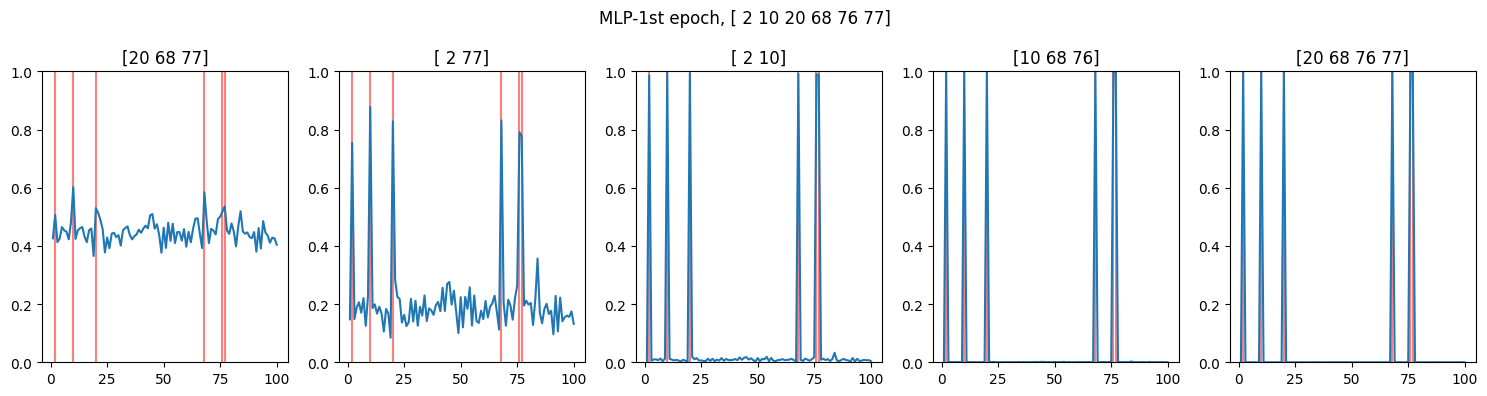

In [7]:
epoch_number = 0
EPOCHS = 5
fig, axes = plt.subplots(1, EPOCHS, figsize=(15, 4))
fig.suptitle(f"MLP-1st epoch, {game.candidates[np.where(game.concept == 1)]}")
for epoch in range(EPOCHS):
    model.train(True)
    train_one_epoch(epoch_number, training_set[epoch*40:((epoch+1)*40-1),:])
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(validation_set):
            vinputs, vlabels = torch.from_numpy(data).float()
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
    epoch_number += 1

    samples = game.make_samples()
    for i in game.candidates[np.where(game.concept==1)]:
        axes[epoch].axvline(i, color='r', alpha=0.5)
    axes[epoch].plot(game.candidates, model(torch.from_numpy(samples).float()).detach().numpy())
    axes[epoch].set_title(f"{game.candidates[np.where(samples==1)]}")
    axes[epoch].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [8]:
model = MLP()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

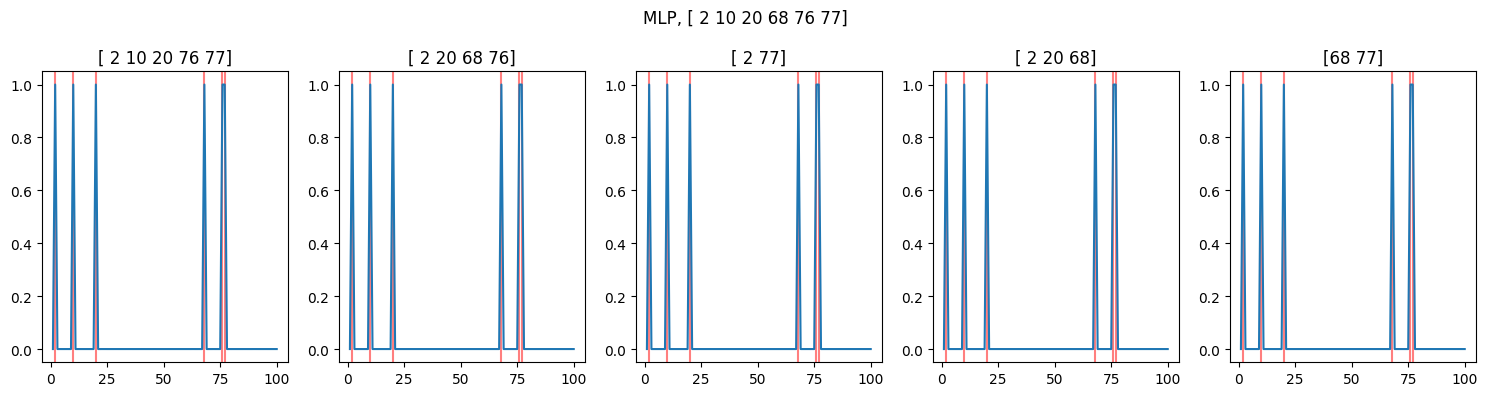

In [9]:
epoch_number = 0
EPOCHS = 5
fig, axes = plt.subplots(1, EPOCHS, figsize=(15, 4))
fig.suptitle(f"MLP, {game.candidates[np.where(game.concept == 1)]}")
for epoch in range(EPOCHS):
    model.train(True)
    train_one_epoch(epoch_number, training_set)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(validation_set):
            vinputs, vlabels = torch.from_numpy(data).float()
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
    epoch_number += 1

    samples = game.make_samples()
    for i in game.candidates[np.where(game.concept==1)]:
        axes[epoch].axvline(i, color='r', alpha=0.5)
    axes[epoch].plot(game.candidates, model(torch.from_numpy(samples).float()).detach().numpy())
    axes[epoch].set_title(f"{game.candidates[np.where(samples==1)]}")

plt.tight_layout()
plt.show()

### MLP with multiple concept

In [10]:
training_set = []
validation_set = []

for _ in range(5):
    game = NumberGame(0.8)
    for _ in range(200):
        training_set.append([game.make_samples(), game.concept])
    for _ in range(10):
        validation_set.append([game.make_samples(), game.concept])

training_set = np.array(training_set)
validation_set = np.array(validation_set)

In [11]:
model = MLP()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
game = NumberGame(0.9)

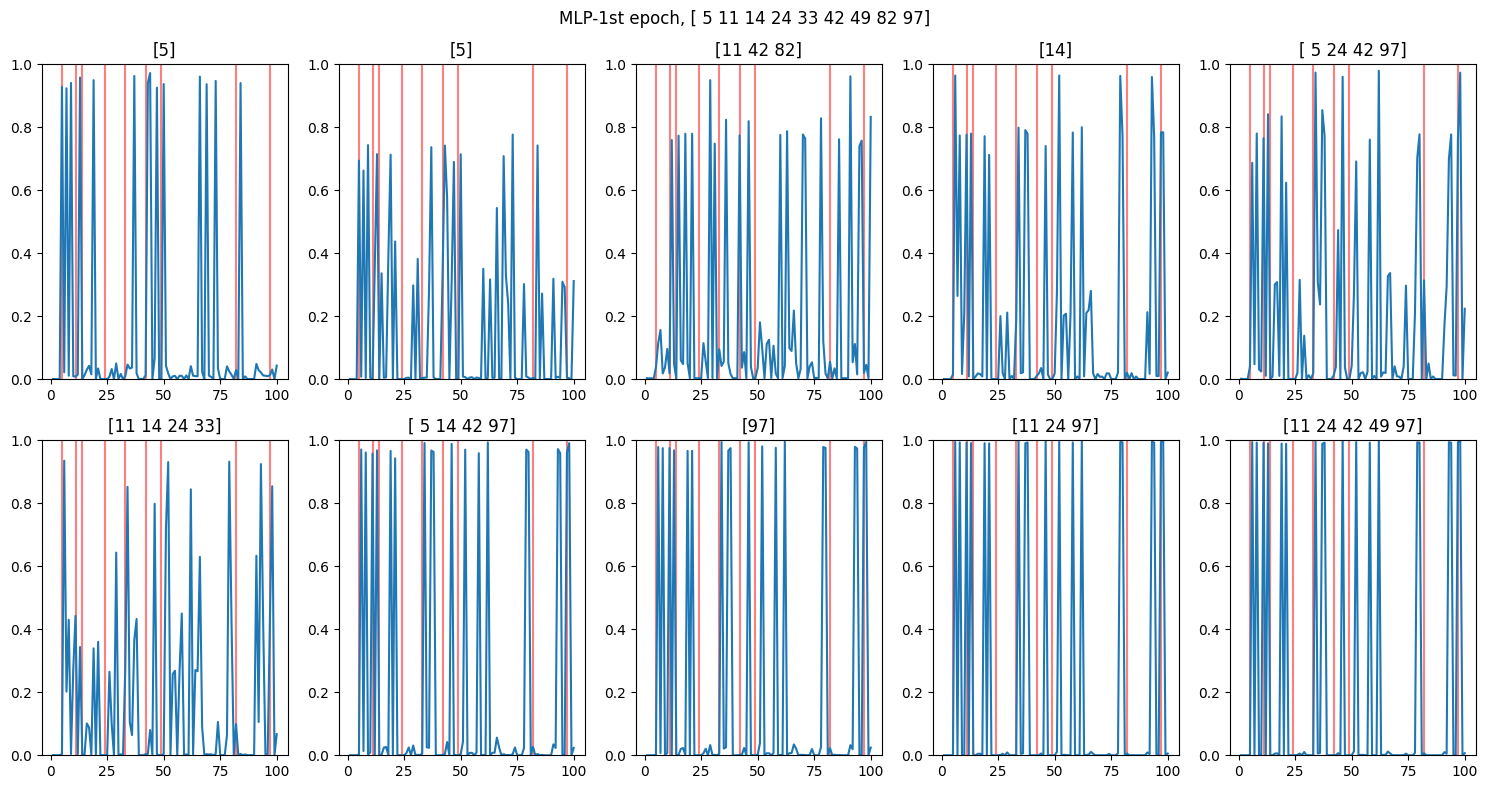

In [21]:
epoch_number = 0
EPOCHS = 10
fig, axes = plt.subplots(2, int(EPOCHS/2), figsize=(15, 8))
fig.suptitle(f"MLP-1st epoch, {game.candidates[np.where(game.concept == 1)]}")
for epoch in range(EPOCHS):
    model.train(True)
    train_one_epoch(epoch_number, training_set[epoch*100:((epoch+1)*200-1),:])
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(validation_set):
            vinputs, vlabels = torch.from_numpy(data).float()
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
    epoch_number += 1

    samples = game.make_samples()
    for i in game.candidates[np.where(game.concept==1)]:
        axes[epoch//5, epoch % 5].axvline(i, color='r', alpha=0.5)
    axes[epoch//5, epoch % 5].plot(game.candidates, model(torch.from_numpy(samples).float()).detach().numpy())
    axes[epoch//5, epoch % 5].set_title(f"{game.candidates[np.where(samples==1)]}")
    axes[epoch//5, epoch % 5].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [22]:
model = MLP()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

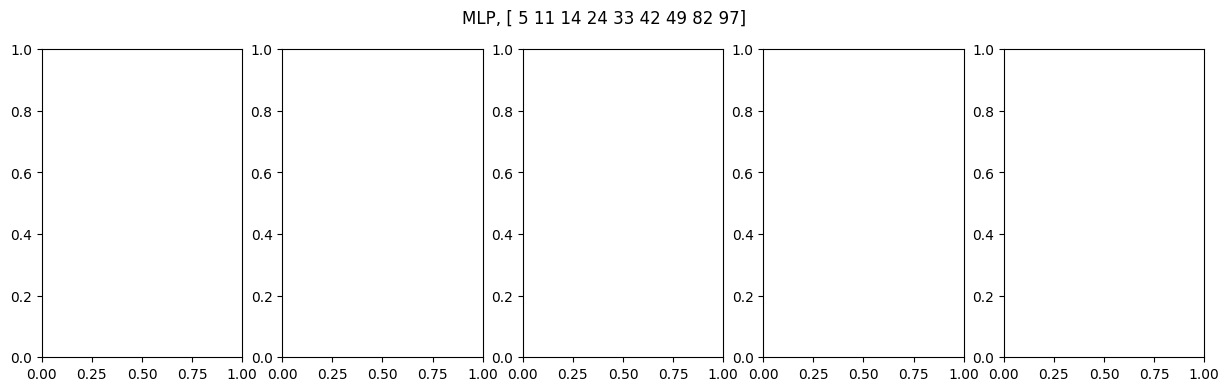

In [23]:
epoch_number = 0
EPOCHS = 10
fig, axes = plt.subplots(2, EPOCHS//2, figsize=(15, 4))
fig.suptitle(f"MLP, {game.candidates[np.where(game.concept == 1)]}")
for epoch in range(EPOCHS):
    model.train(True)
    train_one_epoch(epoch_number, training_set)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(validation_set):
            vinputs, vlabels = torch.from_numpy(data).float()
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
    epoch_number += 1

    samples = game.make_samples()
    for i in game.candidates[np.where(game.concept==1)]:
        axes[epoch//5, epoch % 5].axvline(i, color='r', alpha=0.5)
    axes[epoch//5, epoch % 5].plot(game.candidates, model(torch.from_numpy(samples).float()).detach().numpy())
    axes[epoch//5, epoch % 5].set_title(f"{game.candidates[np.where(samples==1)]}")
    axes[epoch//5, epoch % 5].set_ylim(0, 1)

plt.tight_layout()
plt.show()